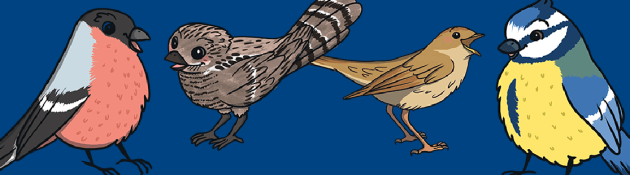


## ***Multi Class Bird Species Classification***

**Name:** Mysha Nahiyan Shemontee<br>
**Student ID:** 102773618 <br>
**Email:** *myshaaa31ns@gmail.com* | *mysha.swin24@gmail.com* | *102773618@students.swinburne.edu.my*<br>

✌

pip installing specific version of tf and tf_hub because of compatibility mismatch between the new version of Keras (v3.x) and TensorFlow Hub

[Reference is taken from this link](https://alishohadaee.medium.com/recent-compatibility-issues-in-transfer-learning-with-tensorflow-hub-da317e6307aa)

In [ ]:
!pip install --upgrade tensorflow==2.13 tensorflow_hub==0.14

#Importing the Libraries

In [ ]:

# Mounting Google Drive to access the dataset stored in drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Standard Python library imports and dependencies

import os  # For interacting with the file system
import zipfile  # For extracting zip files
from os import listdir  # To list files in directories

In [ ]:
# Third-party library imports

import matplotlib.pyplot as plt  # For data visualization
import numpy as np  # For handling arrays
from matplotlib import image  # For loading image data
from sklearn.metrics import classification_report  # For generating classification reports
import tensorflow as tf  # Main library for machine learning
import tensorflow_hub as tf_hub  # TensorFlow Hub for pre-trained models
from keras.utils import Sequence, to_categorical  # Keras utilities for generating batches of data


In [ ]:
# TensorFlow and Keras imports

from tensorflow.keras import layers, regularizers, Sequential  # Regularizers for L1/L2, Sequential models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint  # Callbacks to prevent overfitting and save best models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization  # Layers used for CNN models
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom # for data augmentation
from tensorflow.keras.losses import CategoricalCrossentropy  # Loss function for multi-class classification
from tensorflow.keras.metrics import TopKCategoricalAccuracy  # Metric to measure top-k accuracy
from tensorflow.keras.models import Sequential  # To build Sequential models
from tensorflow.keras.optimizers import Adam  # Optimizer used for training
from tensorflow.keras import layers, Sequential  # Additional imports for defining model architecture
from tensorflow.keras.metrics import TopKCategoricalAccuracy  # Metric for top-k classification accuracy
from tensorflow.keras.utils import to_categorical  # Utility to one-hot encode the labels


#Loading the Dataset

In [ ]:
# Unzipping the dataset /Train

local_zip = '/content/drive/MyDrive/AML/Train.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')  # Extracting the content to a tmp directory
zip_ref.close()

In [ ]:
# Unzipping the dataset /Test

local_zip = '/content/drive/MyDrive/AML/Test.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')  # Extract the content to a tmp directory
zip_ref.close()

In [ ]:
# Defining paths to the extracted train and test image folders

TestPath = '/tmp/Test'
TrainPath = '/tmp/Train'

In [ ]:
# List file names to verify extraction
test_fnames = os.listdir(TestPath)
print(test_fnames[:10])

train_fnames = os.listdir(TrainPath)
print(train_fnames[:10])

In [ ]:
# Print out the total number of images in the training and testing sets

print('total training images:', len(train_fnames))
print('total testing images:', len(test_fnames))

# Data Processing

In [ ]:
# Define image size (224x224) and a helper function to normalize images
IMG_SIZE = 224
def _normalize_img(img):
    """
    Normalize image by rescaling pixel values to [0, 1] and resizing.
    """
    img = tf.cast(img, tf.float32) / 255.  # Rescale pixel values to [0, 1]
    img = tf.image.resize(img,  (IMG_SIZE, IMG_SIZE), method='bilinear')  # Resize the image to 224x224
    return img

In [ ]:
# Load the path and label information from the text files for both train and test sets
train_info = '/content/drive/MyDrive/AML/train.txt'
with open(train_info) as txt_file:
    lines =  [x.strip() for x in txt_file.readlines()]  # Read each line and remove any extra spaces
x_train_path = [x.split(' ')[0] for x in lines]  # Extract the image paths
y_train = [x.split(' ')[1] for x in lines]  # Extract the corresponding labels

In [ ]:
test_info = '/content/drive/MyDrive/AML/test.txt'
with open(test_info) as txt_file:
    lines =  [x.strip() for x in txt_file.readlines()]  # Read each line and remove any extra spaces
x_test_path = [x.split(' ')[0] for x in lines]  # Extract the image paths
y_test = [x.split(' ')[1] for x in lines]  # Extract the corresponding labels

In [ ]:
# Function to load and preprocess images (rescale pixel values and resize to 224x224)
def load_and_preprocess_data(image_paths, labels):
    images = []
    for path in image_paths:
        img_data = image.imread(path)  # Read image from path
        img_data = _normalize_img(img_data)  # Normalize image
        images.append(img_data)
    return np.array(images), np.array(labels)  # Return images and labels as numpy arrays

In [ ]:
# Custom Keras Data Generator class to handle data loading and batching
class KerasDataGenerator(Sequence):
    """
    Data Generator for Keras models.
    """

    def __init__(self, id_list, label_map, dim=(224,224), channels=3, num_classes=10, batch_sz=64, randomize=True):
        """
        Initialize the data generator with image dimensions, batch size, and other parameters.
        """
        self.dim = dim
        self.batch_sz = batch_sz
        self.label_map = label_map
        self.id_list = id_list
        self.channels = channels
        self.num_classes = num_classes
        self.randomize = randomize
        self._epoch_end()  # Initialize index order

        #
        print("Type of label_map:", type(self.label_map))
        print("Sample entries from label_map:", dict(list(self.label_map.items())[:5]))  # Print first 5 label mappings

    def __len__(self):
        """
        Return the number of batches per epoch.
        """
        return len(self.id_list) // self.batch_sz

    def __getitem__(self, idx):
        """
        Generate and return one batch of data.
        """
        index_range = slice(idx * self.batch_sz, (idx + 1) * self.batch_sz)  # Define batch index range
        batch_ids = [self.id_list[i] for i in self.indexes[index_range]]  # Get batch image IDs
        return self._generate_data(batch_ids)

    def _epoch_end(self):
        """
        Update indexes after each epoch. Shuffle if randomize is set to True.
        """
        self.indexes = np.arange(len(self.id_list))  # Create array of indexes
        if self.randomize:
            np.random.shuffle(self.indexes)  # Shuffle the indexes for randomization

    def _load_and_preprocess_image(self, image_path):
        """
        Load and preprocess image by resizing and normalizing.
        """
        img_data = tf.image.decode_image(tf.io.read_file(image_path))  # Read image from disk
        img_data = tf.image.resize(img_data, self.dim)  # Resize image to specified dimensions
        return self._normalize_image(img_data)

    @staticmethod
    def _normalize_image(img):
        """
        Normalize the image by scaling pixel values to [0, 1].
        """
        return img / 255.0  # Normalize pixel values to [0, 1]

    def _generate_data(self, batch_ids):
        """
        Generate a batch of data and labels from the provided batch IDs.
        """
        X = np.zeros((self.batch_sz, *self.dim, self.channels))  # Initialize empty array for image data
        y = np.zeros((self.batch_sz), dtype=int)  # Initialize empty array for labels

        for idx, image_id in enumerate(batch_ids):
            X[idx] = self._load_and_preprocess_image(image_id)  # Load and preprocess the image


            if image_id not in self.label_map:
                print(f"Error: {image_id} not found in label_map!")
                print("Available keys in label_map:", list(self.label_map.keys()))  # Print available keys in the label map

            y[idx] = self.label_map[image_id]  # Assign the corresponding label

        return X, to_categorical(y, self.num_classes)  # Return images and one-hot encoded labels


In [ ]:
# Configuration for the custom data generator
config = {
    'dim': (224, 224),  # Image dimensions for MobileNetV3 input
    'batch_sz': 64,  # Batch size (adjust based on memory)
    'num_classes': 200,  # Number of bird species (CUB-200 dataset)
    'channels': 3,  # RGB images
    'randomize': True  # Shuffle data
}

# Constructing full paths for train and test images
train_image_fullpaths = [TrainPath + '/' + fname for fname in x_train_path]  # Full path for training images
test_image_fullpaths = [TestPath + '/' + fname for fname in x_test_path]  # Full path for test images

# Organizing data in dictionary format for train and test sets (mapping paths to labels)
train_mapping = dict(zip(train_image_fullpaths, y_train))  # Mapping image paths to labels for training data
test_mapping = dict(zip(test_image_fullpaths, y_test))  # Mapping image paths to labels for testing data


# Create data generators for training and testing
train_generator = KerasDataGenerator(list(train_mapping.keys()), train_mapping, **config)
val_generator = KerasDataGenerator(list(test_mapping.keys()), test_mapping, **config)

# Basic model without mitigating overfitting

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import TopKCategoricalAccuracy
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_hub as tf_hub
import matplotlib.pyplot as plt

In [ ]:
# URL to fetch MobileNetV3 pre-trained weights from TensorFlow Hub
mobilenet_v3_url = "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/classification/5"


## Training the model

In [ ]:
# Check current versions of TensorFlow and TensorFlow Hub
import tensorflow as tf
import tensorflow_hub as hub

print(tf.__version__)
print(hub.__version__)


In [ ]:
import tensorflow as tf
import tensorflow_hub as tf_hub
m = tf.keras.Sequential([
    hub.KerasLayer("https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/tf2-preview-classification/4", output_shape=[1001])
])
m.build([None, 224, 224, 3])  # Batch input shape.

In [ ]:
import tensorflow as tf
import tensorflow_hub as tf_hub
# Load MobileNetV3 pre-trained model as a feature extractor
mobilenet_v3_feature_extractor = tf_hub.KerasLayer(mobilenet_v3_url, input_shape=(224, 224, 3))

# Freezing the layers of the pre-trained model so that they won't be updated during training
mobilenet_v3_feature_extractor.trainable = False

# Constructing the basic neural network architecture
# Input layer takes images of size 224x224x3 (RGB images)
# MobileNetV3 acts as the feature extractor, and a Dense layer with 200 units (for 200 bird species) and softmax activation
# The softmax activation is used because it's a multi-class classification problem.
basic_model = Sequential([
    layers.InputLayer(input_shape=(224, 224, 3)),
    mobilenet_v3_feature_extractor,
    layers.Dense(units=200, activation='softmax')  # 200 output units for 200 bird species
], name='basic_mobilenet_v3')

# Setting up the top-1 accuracy metric to monitor how well the model predicts the correct class (out of 200)
top_1_accuracy = TopKCategoricalAccuracy(k=1)


# Optimizer: Adam is used because it's efficient and adaptive in adjusting learning rates during training.
# It's a good default optimizer for most cases.
# Loss function: Categorical Crossentropy is chosen as it's standard for multi-class classification,
# where the model predicts class probabilities, and the loss function measures how far those predictions are from the true labels.
# Metrics: 'accuracy' and top-1 accuracy are used to track how well the model is doing on the classification task.
basic_model.compile(
    optimizer=Adam(learning_rate=0.001),  # Adam optimizer with a learning rate of 0.001
    loss=CategoricalCrossentropy(),  # Categorical Crossentropy is appropriate for multi-class classification
    metrics=['accuracy', top_1_accuracy]  # Track accuracy and top-1 accuracy
)

# Display the model architecture to understand the structure and number of parameters
basic_model.summary()


# EarlyStopping is used to stop training if the model stops improving, preventing unnecessary epochs
early_stop_criteria = EarlyStopping(verbose=1, patience=3)

# Train the model using the data generators for training and validation sets
# Not doing any data augmentation or regularization here to show how the basic model overfits
training_history = basic_model.fit(
    train_generator,  # Training data generator
    epochs=20,  # Train for up to 20 epochs
    validation_data=val_generator,  # Validation data generator
    callbacks=[early_stop_criteria]  # Early stopping to prevent excessive overfitting
)

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy vs. epochs
plt.figure(figsize=(12, 5))

# Plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(training_history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(training_history.history['val_accuracy'], label='Validation Accuracy', color='orange', linestyle='--')

# Configure the first subplot (Training Accuracy)
plt.title('Training and Validation Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Plot training and validation loss vs. epochs
plt.subplot(1, 2, 2)
plt.plot(training_history.history['loss'], label='Training Loss', color='blue')
plt.plot(training_history.history['val_loss'], label='Validation Loss', color='orange', linestyle='--')

# Configure the second subplot (Loss)
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Show the plots
plt.tight_layout()
plt.show()


## Evaluating the model

In [ ]:
def average_accuracy_per_class(model, generator):
    # Initialize lists to store the correct predictions and total counts for each of the 200 classes
    correct_counts = [0] * 200
    total_counts = [0] * 200

    # Loop through the batches of images and labels in the generator
    for images, labels in generator:
        # Get model predictions for the batch of images
        predictions = model.predict(images)

        # Convert predictions and labels to class indices
        predicted_classes = tf.argmax(predictions, axis=1)
        true_classes = tf.argmax(labels, axis=1)

        # Update the correct and total counts for each class
        for i in range(len(true_classes)):
            total_counts[true_classes[i]] += 1  # Increase total count for the true class
            if predicted_classes[i] == true_classes[i]:  # If prediction is correct
                correct_counts[predicted_classes[i]] += 1  # Increase correct count for the predicted class

    # Compute the average accuracy for each class
    average_accuracies = [correct / total if total != 0 else 0 for correct, total in zip(correct_counts, total_counts)]

    # Return the overall average accuracy across all classes
    return sum(average_accuracies) / len(average_accuracies)


# Compute average accuracy per class on training and validation datasets
train_avg_acc_per_class = average_accuracy_per_class(basic_model, train_generator)
val_avg_acc_per_class = average_accuracy_per_class(basic_model, val_generator)

# Print the average accuracy per class for both training and validation sets
print("\nAverage Accuracy Per Class (Training): {:.2f}%".format(train_avg_acc_per_class * 100))
print("Average Accuracy Per Class (Validation): {:.2f}%".format(val_avg_acc_per_class * 100))


# Evaluate the model on the training and validation sets to get loss and accuracy metrics
train_evaluation = basic_model.evaluate(train_generator)
validation_evaluation = basic_model.evaluate(val_generator)

# Unpack the evaluation results: [loss, accuracy, top-1 accuracy]
train_loss, train_acc, train_top1_acc = train_evaluation
val_loss, val_acc, val_top1_acc = validation_evaluation

# Print the metrics for training data
print('\nTraining Metrics:')
print('Loss:', train_loss)
print('Accuracy: {:.2f}%'.format(train_acc * 100))  # Convert accuracy to percentage
print('Top 1 Accuracy: {:.2f}%'.format(train_top1_acc * 100))  # Convert top-1 accuracy to percentage

# Print the metrics for validation data
print('\nValidation Metrics:')
print('Loss:', val_loss)
print('Accuracy: {:.2f}%'.format(val_acc * 100))  # Convert accuracy to percentage
print('Top 1 Accuracy: {:.2f}%'.format(val_top1_acc * 100))  # Convert top-1 accuracy to percentage


# Retrieve the training history object from model training
training_stats = training_history.history

# Extract accuracy and loss values for both training and validation from the training history
train_acc_values = training_stats['accuracy']
val_acc_values = training_stats['val_accuracy']
train_loss_values = training_stats['loss']
val_loss_values = training_stats['val_loss']

# Plot the accuracy and loss over epochs to visualize overfitting (if any)
plt.figure(figsize=(12, 4))

# Plot for Accuracy (Training vs. Validation)
plt.subplot(1, 2, 1)
plt.plot(train_acc_values, label='Training Accuracy')
plt.plot(val_acc_values, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy for Training vs. Validation')

# Plot for Loss (Training vs. Validation)
plt.subplot(1, 2, 2)
plt.plot(train_loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss for Training vs. Validation')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


# Handling overfitting

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import TopKCategoricalAccuracy
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_hub as tf_hub
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

In [ ]:
# URL to fetch MobileNetV3 pre-trained weights from TensorFlow Hub
mobilenet_v3_url = "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/classification/5"

# Load MobileNetV3 base model (pre-trained on ImageNet) using TensorFlow Hub
mobilenet_v3_feature_extractor = tf_hub.KerasLayer(mobilenet_v3_url, input_shape=(224, 224, 3))

# Freeze the MobileNetV3 layers to use as a feature extractor
mobilenet_v3_feature_extractor.trainable = False

In [ ]:
# Data augmentation layer using Keras Sequential API for improved generalization
data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical"),  # Flip images randomly
    layers.RandomRotation(factor=0.1),             # Rotate images by a random factor
    layers.RandomZoom(0.2),                        # Zoom images randomly
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),  # Translate images
    layers.RandomContrast(0.1)                     # Adjust image contrast
], name='data_augmentation')

In [ ]:
# Define L1 and L2 regularization coefficients to prevent overfitting
l1_coeff = 0.001
l2_coeff = 0.001

In [ ]:
# Constructing the neural network model
model_with_regularization = Sequential([
    layers.InputLayer(input_shape=(224, 224, 3)),   # Input layer with specified image size
    data_augmentation,                              # Data augmentation layer
    mobilenet_v3_feature_extractor,                 # MobileNetV3 pre-trained model
    layers.Dropout(rate=0.5),                       # Dropout layer for regularization
    layers.BatchNormalization(),                    # Batch normalization to stabilize training
    layers.Dense(units=200, activation='softmax',   # Final dense layer for classification
                 kernel_regularizer=regularizers.l1_l2(l1_coeff, l2_coeff))  # Apply L1/L2 regularization
], name='custom_neural_net_with_regularization')

In [ ]:
# Compile the model
# Using Adam optimizer with learning rate 0.001 and categorical crossentropy for loss
model_with_regularization.compile(
    optimizer=Adam(learning_rate=0.001),            # Adam optimizer
    loss=CategoricalCrossentropy(),                 # Loss function for multi-class classification
    metrics=['accuracy', TopKCategoricalAccuracy(k=1)]  # Track accuracy and top-1 accuracy
)

# Display the model architecture
model_with_regularization.summary()

In [ ]:
# Set early stopping criteria
early_stop_criteria = EarlyStopping(verbose=1, patience=3)

In [ ]:
import numpy as np
from sklearn.model_selection import KFold


# Create the dataset as an array of image paths
dataset = np.array(train_image_fullpaths)  # Paths to the training images
labels = np.array(y_train)  # Corresponding labels


In [ ]:
# Set up k-fold cross-validation to evaluate model performance on different data splits
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# List to store training histories for each fold
all_histories = []

# dataset and labels are stored in `dataset` and `labels`
for train_idx, val_idx in kfold.split(dataset, labels):
    train_data, val_data = dataset[train_idx], dataset[val_idx]
    train_labels, val_labels = labels[train_idx], labels[val_idx]


    train_generator = KerasDataGenerator(list(train_data), train_mapping, **config)
    val_generator = KerasDataGenerator(list(val_data), train_mapping, **config)

    # Train the model on each fold with the specified number of epochs and validation
    training_history = model_with_regularization.fit(
        train_generator,                             # Training data generator
        epochs=20,                                   # Number of training epochs
        validation_data=val_generator,               # Validation data generator
        callbacks=[early_stop_criteria]              # Apply early stopping to prevent overfitting
    )

    # Store the training history for this fold
    all_histories.append(training_history)

# Visualizing and analyzing Results

In [ ]:
import matplotlib.pyplot as plt

# Create a figure for the plots
plt.figure(figsize=(12, 5))

# Loop through each fold's training history
for i, history in enumerate(all_histories):
    # Plot training accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label=f'Train Accuracy - Fold {i+1}')
    plt.plot(history.history['val_accuracy'], label=f'Val Accuracy - Fold {i+1}', linestyle='--')

# Configure the first subplot (Training Accuracy)
plt.title('Training and Validation Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Plot for training and validation loss
for i, history in enumerate(all_histories):
    # Plot training loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label=f'Train Loss - Fold {i+1}')
    plt.plot(history.history['val_loss'], label=f'Val Loss - Fold {i+1}', linestyle='--')

# Configure the second subplot (Loss)
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Show the plots
plt.tight_layout()
plt.show()


In [ ]:
# Initialize lists to store evaluation metrics
train_evaluations = []
validation_evaluations = []
top_1_train_accuracies = []
top_1_val_accuracies = []

# Loop through each fold to evaluate the model on the train and validation data
for train_idx, val_idx in kfold.split(dataset, labels):

    # Evaluate the model on the training data
    train_eval = model_with_regularization.evaluate(train_generator)
    val_eval = model_with_regularization.evaluate(val_generator)

    train_evaluations.append(train_eval)
    validation_evaluations.append(val_eval)

    # Calculate Top-1 accuracy for train and validation sets
    top_1_train_accuracies.append(train_eval[1])
    top_1_val_accuracies.append(val_eval[1])

# Unpack average metrics for training and validation
avg_train_loss = tf.reduce_mean([x[0] for x in train_evaluations])
avg_train_acc = tf.reduce_mean([x[1] for x in train_evaluations])
avg_val_loss = tf.reduce_mean([x[0] for x in validation_evaluations])
avg_val_acc = tf.reduce_mean([x[1] for x in validation_evaluations])
avg_top_1_train_acc = tf.reduce_mean(top_1_train_accuracies)
avg_top_1_val_acc = tf.reduce_mean(top_1_val_accuracies)

# Display the evaluation metrics
print('\nAverage Training Metrics:')
print('Loss:', avg_train_loss)
print('Accuracy: {:.2f}%'.format(avg_train_acc * 100))
print('Top-1 Accuracy: {:.2f}%'.format(avg_top_1_train_acc * 100))

print('\nAverage Validation Metrics:')
print('Loss:', avg_val_loss)
print('Accuracy: {:.2f}%'.format(avg_val_acc * 100))
print('Top-1 Accuracy: {:.2f}%'.format(avg_top_1_val_acc * 100))


In [ ]:
# Initialize lists to store average accuracy per class for each fold
average_train_acc_per_class_list = []
average_val_acc_per_class_list = []

# Loop through each fold to calculate average accuracy per class
for train_idx, val_idx in kfold.split(dataset, labels):
    # Calculate average accuracy per class for training and validation data
    train_avg_acc_per_class = average_accuracy_per_class(model_with_regularization, train_generator)
    val_avg_acc_per_class = average_accuracy_per_class(model_with_regularization, val_generator)

    average_train_acc_per_class_list.append(train_avg_acc_per_class)
    average_val_acc_per_class_list.append(val_avg_acc_per_class)

# Calculate the average accuracy per class across all folds
avg_train_acc_per_class = tf.reduce_mean(average_train_acc_per_class_list)
avg_val_acc_per_class = tf.reduce_mean(average_val_acc_per_class_list)

# Display the average accuracy per class
print("\nAverage Accuracy Per Class (Training): {:.2f}%".format(avg_train_acc_per_class * 100))
print("Average Accuracy Per Class (Validation): {:.2f}%".format(avg_val_acc_per_class * 100))


In [ ]:
# Visualization: Top-1 accuracy for training and validation sets
plt.figure(figsize=(8, 4))

# Plotting the Top-1 accuracy for training and validation
plt.plot(top_1_train_accuracies, label='Top-1 Training Accuracy', marker='o')
plt.plot(top_1_val_accuracies, label='Top-1 Validation Accuracy', marker='x')
plt.xlabel('Fold Number')
plt.ylabel('Top-1 Accuracy')
plt.legend()
plt.title('Top-1 Accuracy for Training vs. Validation Across Folds')

# Display the plot
plt.tight_layout()
plt.show()


# Saving the Model

In [ ]:
# Save model to specified directory or filename
model_save_path = 'birdie.h5'
model_with_regularization.save(model_save_path)

print(f'Model saved to {model_save_path}')
